In [1]:
import numpy as np
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as td
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [2]:
class CNNAE(nn.Module):
    def __init__(self):
        super(CNNAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Conv2d(32, 64, 7),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.PReLU(),
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

In [4]:
def plot_reconstructions(model, data_loader, n_images=5, device="cpu"):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_images = batch[:n_images].to(device)
            recon_images = model(input_images)
            break

    fig, axes = plt.subplots(2, n_images, figsize=(10, 4))
    for i in range(n_images):
        #or_images
        img = input_images[i].cpu().numpy().transpose(1, 2, 0)
        img_normalized = normalize_image(img)
        axes[0, i].imshow(img_normalized)
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        #re_images
        recon_img = recon_images[i].cpu().numpy().transpose(1, 2, 0)
        recon_img_normalized = normalize_image(recon_img)
        axes[1, i].imshow(recon_img_normalized)
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

    plt.show()

In [5]:
def compute_physical_constraint_loss(output):
    dx = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
    dy = torch.Tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8

    dx = dx.view(1, 1, 3, 3).to(device)
    dy = dy.view(1, 1, 3, 3).to(device)

    grad_x_x = F.conv2d(output[:, 0:1], dx, padding=1)
    grad_x_y = F.conv2d(output[:, 0:1], dy, padding=1)
    grad_y_x = F.conv2d(output[:, 1:2], dx, padding=1)
    grad_y_y = F.conv2d(output[:, 1:2], dy, padding=1)
    grad_z_x = F.conv2d(output[:, 2:3], dx, padding=1)
    grad_z_y = F.conv2d(output[:, 2:3], dy, padding=1)
    grad_z_z = F.conv2d(output[:, 2:3], torch.zeros_like(dy), padding=1)

    div = torch.abs(grad_x_x + grad_x_y) + torch.abs(grad_y_x + grad_y_y) + torch.abs(grad_z_x + grad_z_y + grad_z_z)
    constraint_loss = torch.mean(div)

    return constraint_loss


In [6]:
def compute_physical_constraint_loss2(output):
    Hx_x = torch.gradient(output[:, 0], axis=2)[0]
    Hy_y = torch.gradient(output[:, 1], axis=1)[0]

    if output.shape[1] == 3:
        Hz_z = torch.gradient(output[:, 2], axis=2)[0]
        div_mag = torch.stack([Hx_x, Hy_y, Hz_z], dim=1)
    else:
        div_mag = torch.stack([Hx_x, Hy_y], dim=1)

    constraint_loss = torch.mean(torch.abs(div_mag.sum(dim=1)))
    return constraint_loss



In [7]:
if __name__ == "__main__":
    # %%
    learning_rate = 0.0005
    batch_size = 64
    num_epochs = 100
    alpha = 0.1  # 物理约束损失的权重
    #DEVICE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 初始化网络
    model = CNNAE().to(device)
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练数据加载器
    data = np.load("data4D.npy", allow_pickle=True)
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

    train_data = torch.from_numpy(train_data).to(device)
    test_data = torch.from_numpy(test_data).to(device)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)



    wandb.init(
        # set the wandb project where this run will be logged
        project="MagAE_2D",

        # track hyperparameters and run metadata
        config={
            "learning_rate": learning_rate,
            "architecture": "CNN",
            "dataset": "2DMag",
            "epochs": num_epochs,
            "batch_size": batch_size,
        })


    for epoch in range(num_epochs):
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)

            # 使用物理信息损失函数
            reconstruction_loss = criterion(outputs, data)
            #constraint_loss = compute_physical_constraint_loss(outputs)
            constraint_loss = compute_physical_constraint_loss2(outputs)
            loss = reconstruction_loss + alpha * constraint_loss


            #loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()

        #wandb.log({"Epochs": epoch + 1, "loss": loss.item()})
        wandb.log({"Epochs": epoch + 1, "Total Loss": loss.item(), "Reconstruction Loss": reconstruction_loss.item(), "Constraint Loss": constraint_loss.item()})

        print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, Constraint Loss: {constraint_loss.item():.4f}")

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    with torch.no_grad():
        test_loss = 0
        for data in test_loader:
            data = data.to(device)
            recon_batch = model(data)
            test_loss += criterion(recon_batch, data).item()
        test_loss /= len(test_loader.dataset)
        wandb.log({"test_loss": test_loss})
        print(f"Test Loss: {test_loss:.4f}")


    wandb.finish()

Using device: cuda


wandb: Currently logged in as: dongtianchi (te-st). Use `wandb login --relogin` to force relogin


Epoch [1/100], Total Loss: 0.0636, Reconstruction Loss: 0.0613, Constraint Loss: 0.0230
Epoch [1/100], Loss: 0.0636
Epoch [2/100], Total Loss: 0.0503, Reconstruction Loss: 0.0480, Constraint Loss: 0.0229
Epoch [2/100], Loss: 0.0503
Epoch [3/100], Total Loss: 0.0452, Reconstruction Loss: 0.0431, Constraint Loss: 0.0215
Epoch [3/100], Loss: 0.0452
Epoch [4/100], Total Loss: 0.0383, Reconstruction Loss: 0.0360, Constraint Loss: 0.0232
Epoch [4/100], Loss: 0.0383
Epoch [5/100], Total Loss: 0.0371, Reconstruction Loss: 0.0346, Constraint Loss: 0.0249
Epoch [5/100], Loss: 0.0371
Epoch [6/100], Total Loss: 0.0341, Reconstruction Loss: 0.0315, Constraint Loss: 0.0258
Epoch [6/100], Loss: 0.0341
Epoch [7/100], Total Loss: 0.0396, Reconstruction Loss: 0.0370, Constraint Loss: 0.0266
Epoch [7/100], Loss: 0.0396
Epoch [8/100], Total Loss: 0.0311, Reconstruction Loss: 0.0283, Constraint Loss: 0.0286
Epoch [8/100], Loss: 0.0311
Epoch [9/100], Total Loss: 0.0270, Reconstruction Loss: 0.0238, Constrai

Constraint Loss,▁▁▂▃▆▆▆▆▆▆▇▆▆▆▇▇███▇▇▇▇▇███▇▆▇▆█▆▇▆▇▆▇▆▆
Epochs,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Reconstruction Loss,█▆▄▄▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,█▆▄▄▃▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁
Constraint Loss,0.04369
Epochs,100
Reconstruction Loss,0.00381
Total Loss,0.00818
test_loss,5e-05


In [34]:
with torch.no_grad():
    test_loss = 0.0
    test_recon = 0.0
    test_constrant = 0.0
    for data in test_loader:
        data = data.to(device)
        recon_batch = model(data)
        reconstruction_loss = criterion(recon_batch, data)
        test_recon += reconstruction_loss.item()
        #constraint_loss = compute_physical_constraint_loss(outputs)

        constraint_loss = compute_physical_constraint_loss2(outputs)
        test_constrant += constraint_loss.item()

        loss = reconstruction_loss + alpha * constraint_loss
        test_loss += loss.item()
    test_loss /= len(test_loader.dataset)
    test_recon /= len(test_loader.dataset)
    test_constrant /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.10f}")
    print(f"Reconstruction Loss: {test_recon:.10f}")
    print(f"Constrant Loss: {test_constrant:.10f}")
    print(f"Alpha: {alpha:.10f}")

Test Loss: 0.0000966679
Reconstruction Loss: 0.0000353139
Constrant Loss: 0.0006135392
Alpha: 0.1000000000


In [6]:
#torch.save(model,"AE2D.pkl")

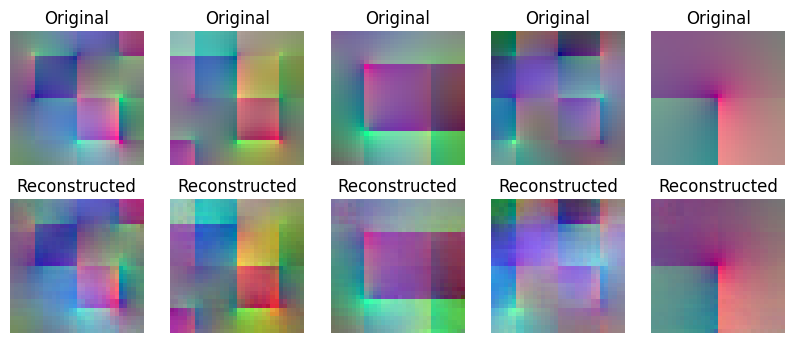

In [8]:

with torch.no_grad():
    plot_reconstructions(model, test_loader, n_images=5, device=device)

In [9]:
# 计算数据大小
original_size = 3 * 32 * 32
compressed_size = 256 * 1 * 1

# 计算压缩率
compression_rate = original_size / compressed_size

print(f"Compression rate: {compression_rate:.4f}")

Compression rate: 12.0000


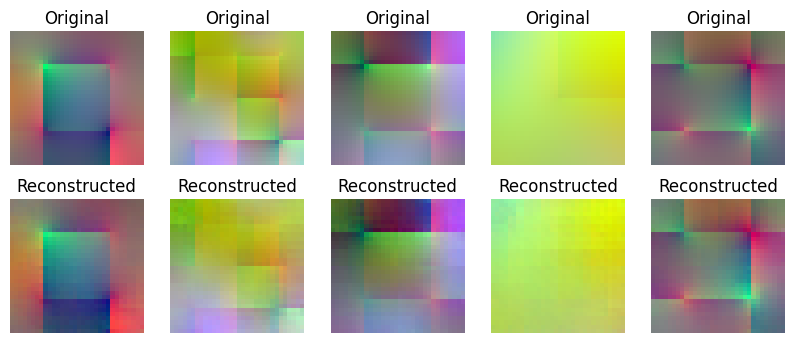

In [10]:
def plot_reconstructions1(model, data_loader, position=(0, 0), n_images=5, device="cpu"):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_images = batch[:n_images].to(device)
            recon_images = model(input_images)
            break

    fig, axes = plt.subplots(2, n_images, figsize=(10, 4))
    for i in range(n_images):
        # Original images
        img = input_images[i].cpu().numpy()[:, position[0], position[1]]
        img_normalized = normalize_image(img)
        axes[0, i].imshow(img_normalized, cmap='viridis')
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        # Reconstructed images
        recon_img = recon_images[i].cpu().numpy()[:, position[0], position[1]]
        recon_img_normalized = normalize_image(recon_img)
        axes[1, i].imshow(recon_img_normalized, cmap='viridis')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

    plt.show()

with torch.no_grad():
    plot_reconstructions(model, test_loader, device="cuda")


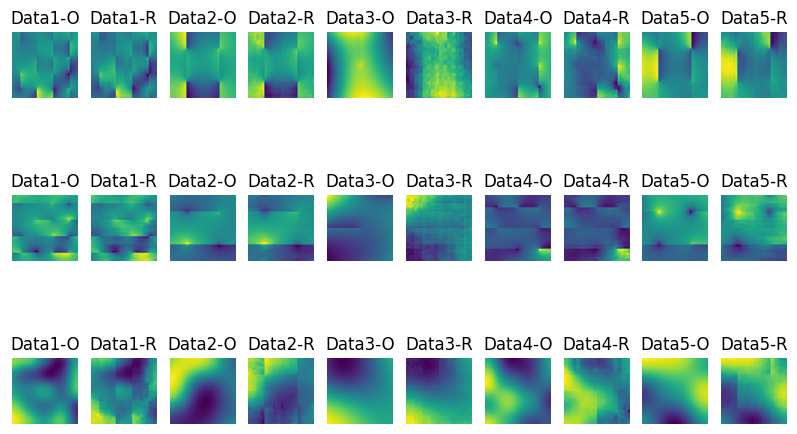

In [11]:
def plot_reconstructions4(model, data_loader, n_images=5, device="cpu"):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_images = batch[:n_images].to(device)
            recon_images = model(input_images)
            break

    fig, axes = plt.subplots(3, 2 * n_images, figsize=(10, 6))

    channel_titles = ['Channel 1', 'Channel 2', 'Channel 3']

    for i in range(n_images):
        for channel in range(3):
            # Original images
            img = input_images[i].cpu().numpy()[channel]
            img_normalized = normalize_image(img)
            axes[channel, i * 2].imshow(img_normalized, cmap='viridis')
            if i == 0:
                axes[channel, i * 2].set_ylabel(channel_titles[channel])
            axes[channel, i * 2].set_title(f"Data{i+1}-O")
            axes[channel, i * 2].axis("off")

            # Reconstructed images
            recon_img = recon_images[i].cpu().numpy()[channel]
            recon_img_normalized = normalize_image(recon_img)
            axes[channel, i * 2 + 1].imshow(recon_img_normalized, cmap='viridis')
            axes[channel, i * 2 + 1].set_title(f"Data{i+1}-R")
            axes[channel, i * 2 + 1].axis("off")

    plt.show()



with torch.no_grad():
    plot_reconstructions4(model, test_loader, n_images=5, device=device)

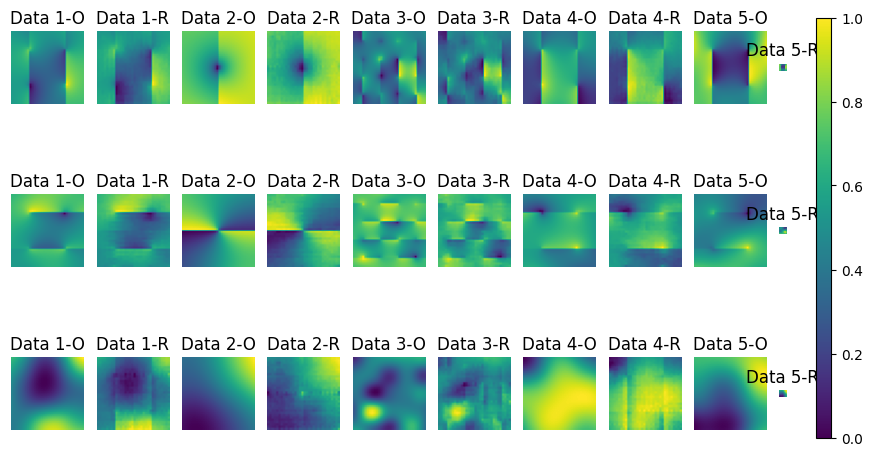

In [12]:
import matplotlib as mpl

def plot_reconstructions5(model, data_loader, n_images=5, device="cpu"):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_images = batch[:n_images].to(device)
            recon_images = model(input_images)
            break

    fig, axes = plt.subplots(3, 2 * n_images, figsize=(10, 6), gridspec_kw={'width_ratios': [1] * (2 * n_images - 1) + [0.1]})

    channel_titles = ['Channel 1', 'Channel 2', 'Channel 3']

    for i in range(n_images):
        for channel in range(3):
            # Original images
            img = input_images[i].cpu().numpy()[channel]
            img_normalized = normalize_image(img)
            im = axes[channel, i * 2].imshow(img_normalized, cmap='viridis', vmin=0, vmax=1)
            if i == 0:
                axes[channel, i * 2].set_ylabel(channel_titles[channel])
            axes[channel, i * 2].set_title(f"Data {i+1}-O")
            axes[channel, i * 2].axis("off")

            # Reconstructed images
            recon_img = recon_images[i].cpu().numpy()[channel]
            recon_img_normalized = normalize_image(recon_img)
            axes[channel, i * 2 + 1].imshow(recon_img_normalized, cmap='viridis', vmin=0, vmax=1)
            axes[channel, i * 2 + 1].set_title(f"Data {i+1}-R")
            axes[channel, i * 2 + 1].axis("off")

    # Add colorbar
    cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='viridis'), cax=cbar_ax)
    plt.show()

with torch.no_grad():
    plot_reconstructions5(model, test_loader, n_images=5, device=device)


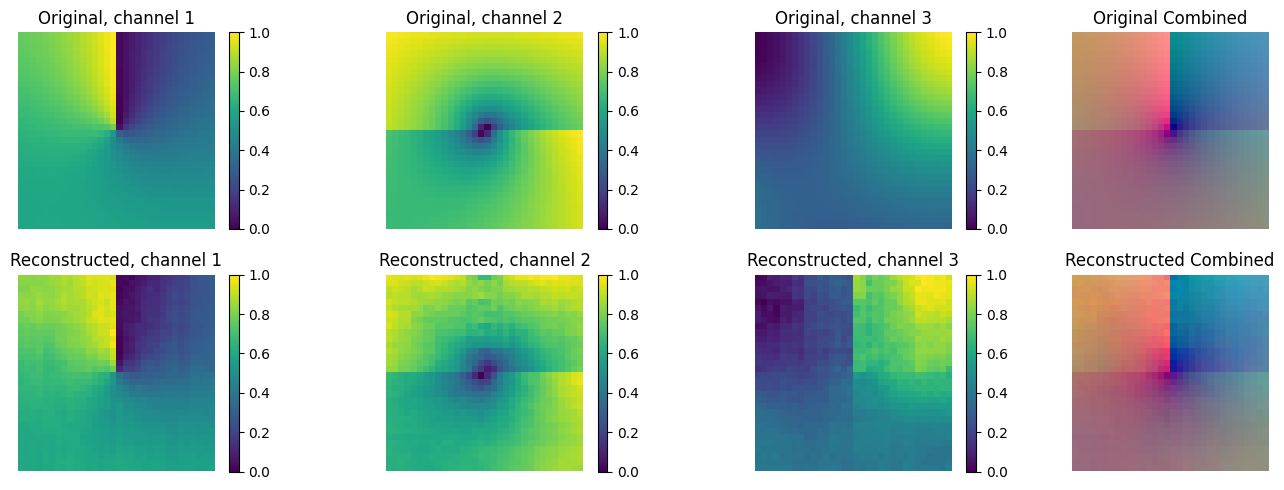

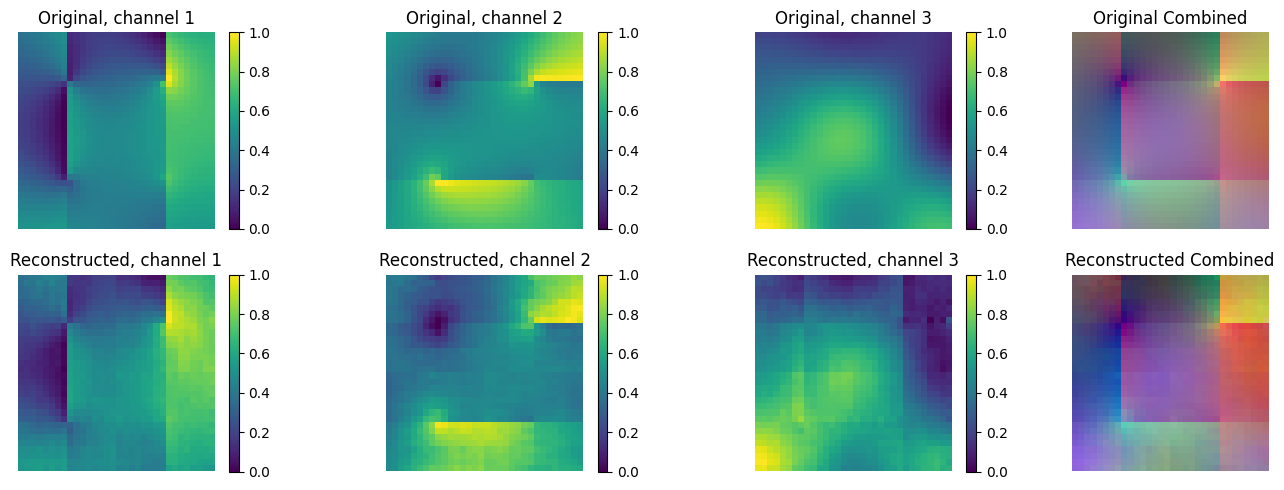

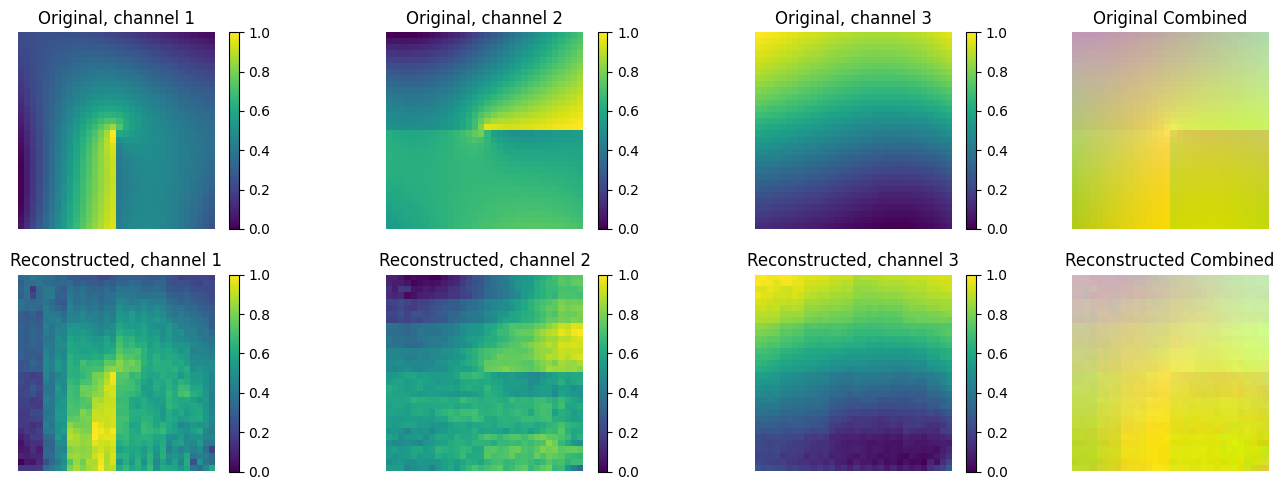

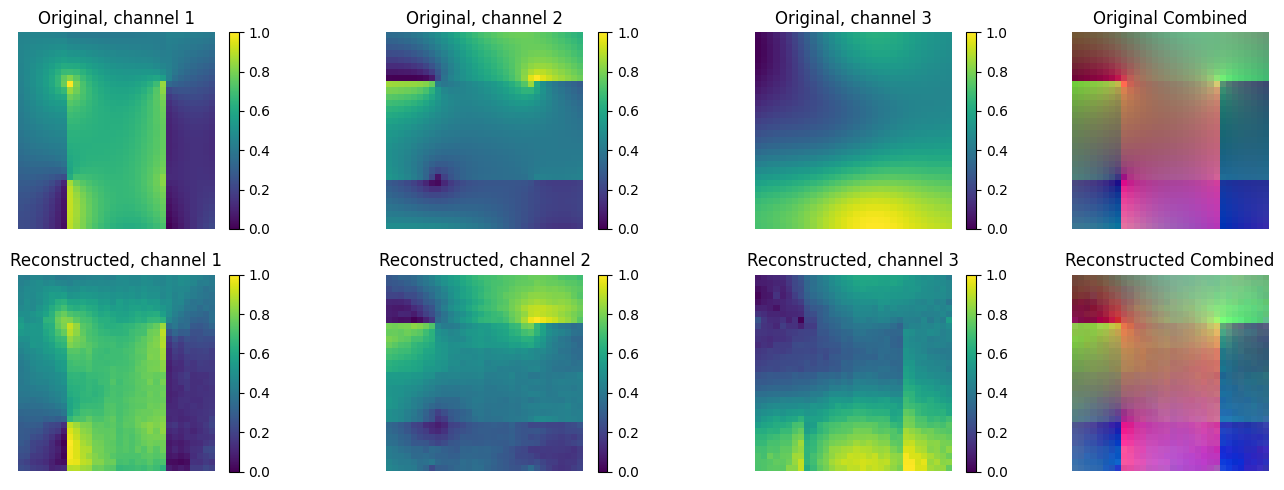

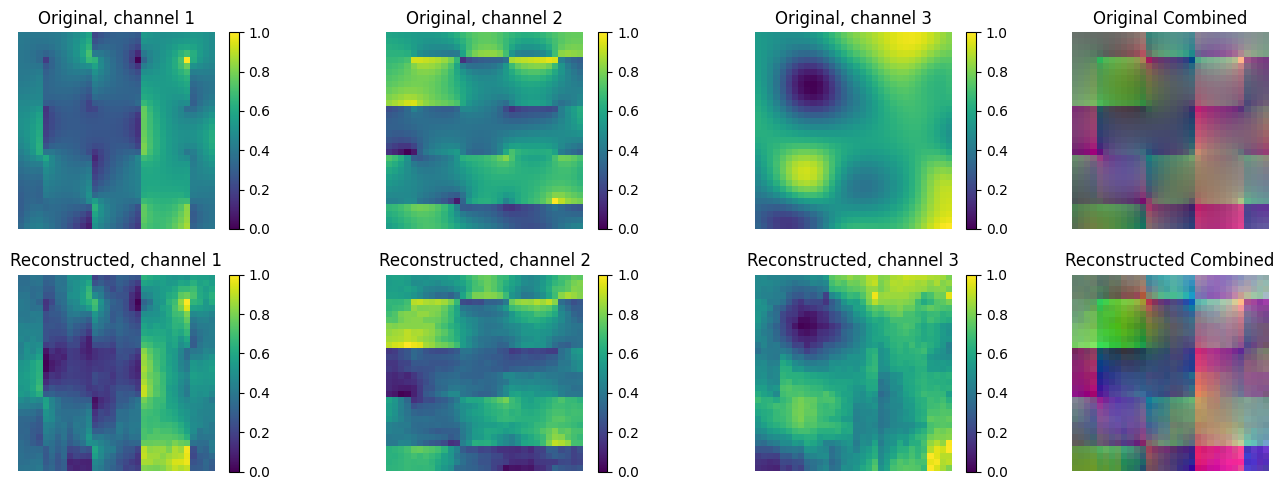

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_reconstructions8(model, data_loader, n_images=5, device="cpu"):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_images = batch[:n_images].to(device)
            recon_images = model(input_images)
            break

    n_channels = 3

    for i in range(n_images):
        fig, axes = plt.subplots(2, n_channels + 1, figsize=(15, 5))

        for c in range(n_channels):
            # Original images
            img = input_images[i][c].cpu().numpy()
            img_normalized = normalize_image(img)
            im = axes[0, c].imshow(img_normalized, cmap='viridis')
            axes[0, c].set_title(f"Original, channel {c+1}")
            axes[0, c].axis("off")
            plt.colorbar(im, ax=axes[0, c], fraction=0.046, pad=0.04)

            # Reconstructed images
            recon_img = recon_images[i][c].cpu().numpy()
            recon_img_normalized = normalize_image(recon_img)
            im = axes[1, c].imshow(recon_img_normalized, cmap='viridis')
            axes[1, c].set_title(f"Reconstructed, channel {c+1}")
            axes[1, c].axis("off")
            plt.colorbar(im, ax=axes[1, c], fraction=0.046, pad=0.04)

        # Original images combined
        img_combined = input_images[i].cpu().numpy().transpose(1, 2, 0)
        img_combined_normalized = normalize_image(img_combined)
        axes[0, n_channels].imshow(img_combined_normalized)
        axes[0, n_channels].set_title("Original Combined")
        axes[0, n_channels].axis("off")

        # Reconstructed images combined
        recon_img_combined = recon_images[i].cpu().numpy().transpose(1, 2, 0)
        recon_img_combined_normalized = normalize_image(recon_img_combined)
        axes[1, n_channels].imshow(recon_img_combined_normalized)
        axes[1, n_channels].set_title("Reconstructed Combined")
        axes[1, n_channels].axis("off")

        plt.tight_layout()
        plt.show()

with torch.no_grad():
    plot_reconstructions8(model, test_loader, device="cuda")



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


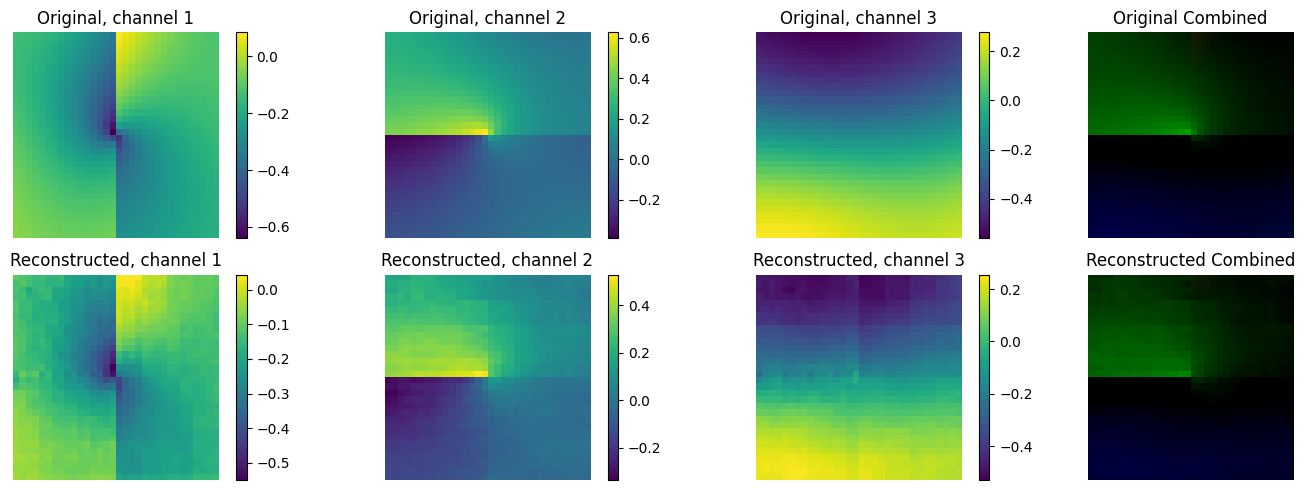

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


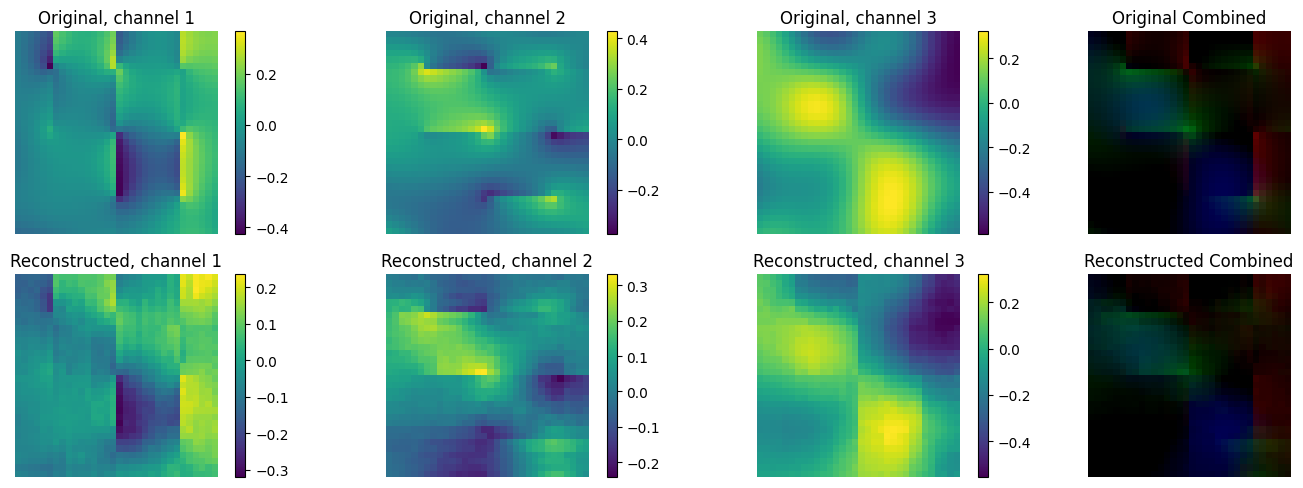

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


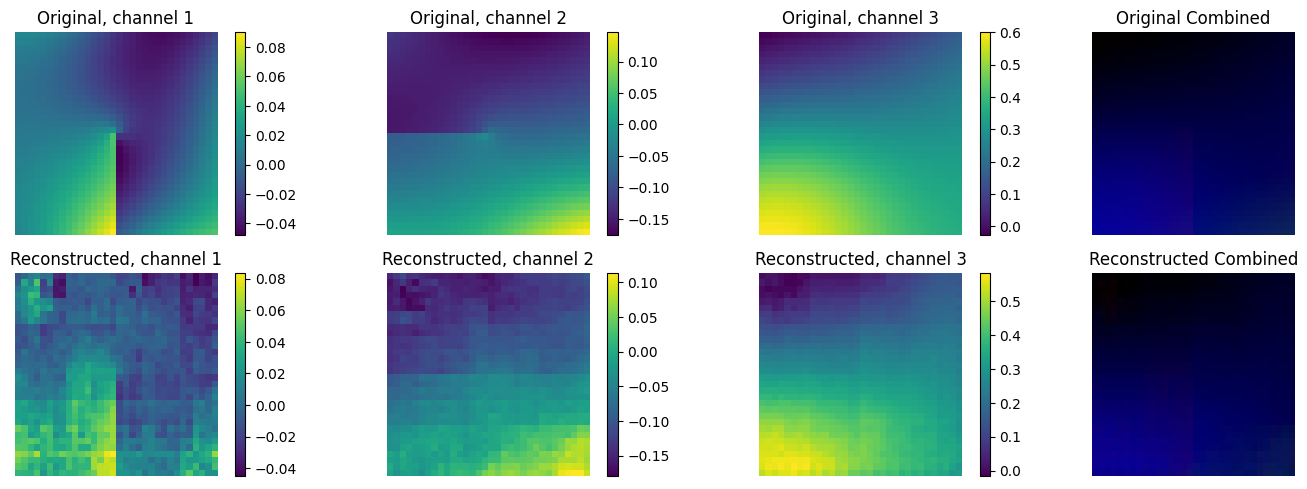

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


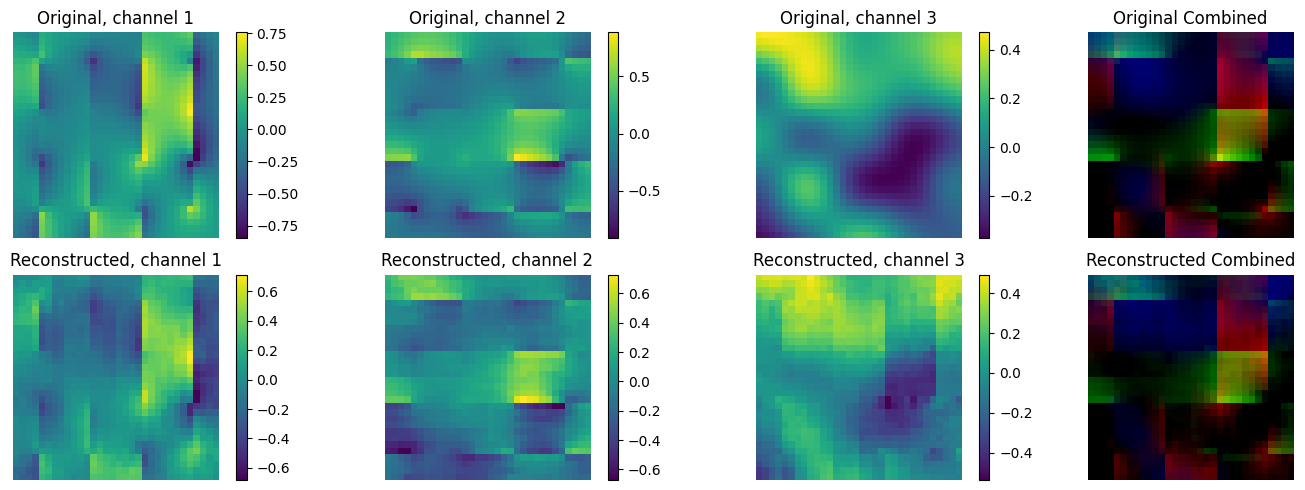

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


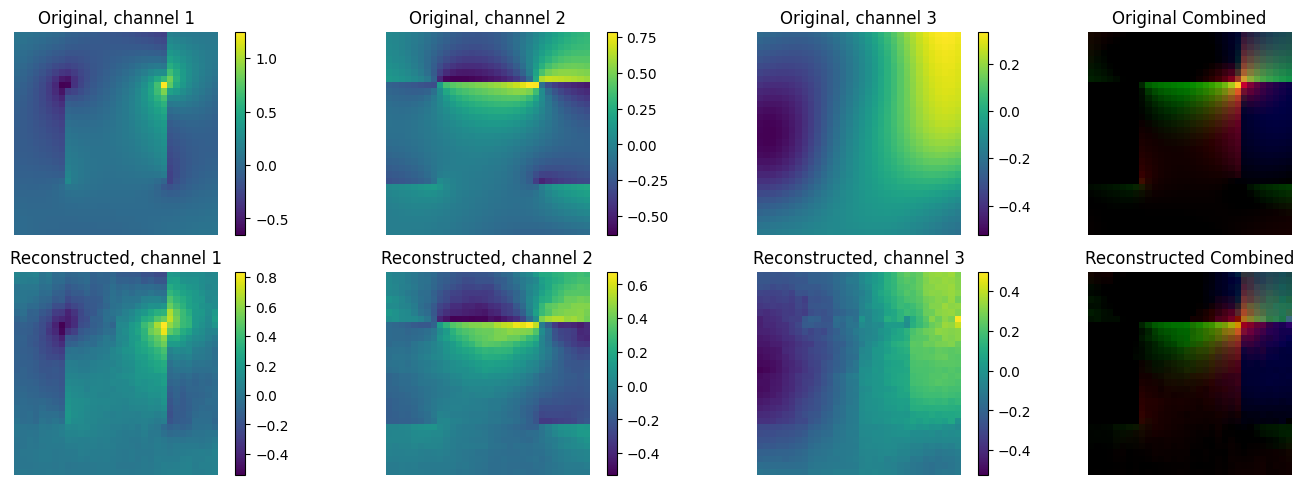

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_reconstructions9(model, data_loader, n_images=5, device="cpu"):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_images = batch[:n_images].to(device)
            recon_images = model(input_images)
            break

    n_channels = 3

    for i in range(n_images):
        fig, axes = plt.subplots(2, n_channels + 1, figsize=(15, 5))

        for c in range(n_channels):
            # Original images
            img = input_images[i][c].cpu().numpy()
            im = axes[0, c].imshow(img, cmap='viridis')
            axes[0, c].set_title(f"Original, channel {c+1}")
            axes[0, c].axis("off")
            plt.colorbar(im, ax=axes[0, c], fraction=0.05, pad=0.05)

            # Reconstructed images
            recon_img = recon_images[i][c].cpu().numpy()
            im = axes[1, c].imshow(recon_img, cmap='viridis')
            axes[1, c].set_title(f"Reconstructed, channel {c+1}")
            axes[1, c].axis("off")
            plt.colorbar(im, ax=axes[1, c], fraction=0.05, pad=0.05)

        # Original images combined
        img_combined = input_images[i].cpu().numpy().transpose(1, 2, 0)
        axes[0, n_channels].imshow(img_combined)
        axes[0, n_channels].set_title("Original Combined")
        axes[0, n_channels].axis("off")

        # Reconstructed images combined
        recon_img_combined = recon_images[i].cpu().numpy().transpose(1, 2, 0)
        axes[1, n_channels].imshow(recon_img_combined)
        axes[1, n_channels].set_title("Reconstructed Combined")
        axes[1, n_channels].axis("off")

        plt.tight_layout()
        plt.show()

with torch.no_grad():
    plot_reconstructions9(model, test_loader, device="cuda")

In [21]:
def mape_loss(output, target):
    return torch.mean(torch.abs((target - output) / (target + 1e-8))) * 100


model.eval()
with torch.no_grad():
    total_mape = 0
    for batch in test_loader:
        input_images = batch.to(device)
        outputs = model(input_images)
        total_mape += mape_loss(outputs, input_images).item()
    print("MAPE: ", total_mape / len(test_loader))


MAPE:  135.3618655204773


In [27]:
#percentage
def mape_loss(output, target):
    return torch.mean(torch.abs((target - output) / (target + 1e-8))) * 100

model.eval()
with torch.no_grad():
    for batch in test_loader:
        # data
        inputs = batch.to(device)
        single_input = inputs[9]

        single_input = single_input.unsqueeze(0)  # (1, 3, 32, 32)
        print(single_input)

        output = model(single_input)
        print(output)
        mape = mape_loss(output, single_input)
        print("MAPE: ", mape.item())
        break  #


tensor([[[[ 0.0966,  0.1212,  0.1536,  ..., -0.1446, -0.1394, -0.1448],
          [ 0.0534,  0.0723,  0.0984,  ..., -0.1314, -0.1256, -0.1304],
          [ 0.0029,  0.0161,  0.0350,  ..., -0.1093, -0.1042, -0.1093],
          ...,
          [-0.2389, -0.2241, -0.2086,  ...,  0.2488,  0.2487,  0.2617],
          [-0.2294, -0.2161, -0.2010,  ...,  0.2374,  0.2447,  0.2622],
          [-0.2234, -0.2105, -0.1949,  ...,  0.2174,  0.2316,  0.2539]],

         [[-0.0743, -0.1165, -0.1652,  ..., -0.1496, -0.1400, -0.1295],
          [-0.0666, -0.1163, -0.1720,  ..., -0.1927, -0.1752, -0.1575],
          [-0.0571, -0.1135, -0.1774,  ..., -0.2435, -0.2175, -0.1928],
          ...,
          [-0.0242, -0.0144, -0.0060,  ..., -0.2997, -0.3019, -0.2984],
          [-0.0349, -0.0275, -0.0206,  ..., -0.2957, -0.3080, -0.3144],
          [-0.0453, -0.0414, -0.0367,  ..., -0.3001, -0.3202, -0.3345]],

         [[-0.0244, -0.0238, -0.0222,  ...,  0.1730,  0.1885,  0.2002],
          [-0.0362, -0.0368, -

In [36]:
a = torch.tensor(-0.2442)
a1 = torch.tensor(-0.2950)
print(mape_loss(a,a1))

b = torch.tensor(0.0966)
b1 = torch.tensor(0.1110)
print(mape_loss(b,b1))

tensor(17.2203)
tensor(12.9730)


In [45]:
model.eval()

# 创建一个空列表用于存储 MAPE 值大于 100 的样本
high_error_samples = []

with torch.no_grad():
    for batch in test_loader:
        input_images = batch.to(device)
        outputs = model(input_images)
        mape = mape_loss(outputs, input_images)

        # 找出 MAPE 值大于 100 的样本
        high_error_mask = mape > 100
        high_error_images = input_images[high_error_mask]
        high_error_outputs = outputs[high_error_mask]
        high_error_mape_values = mape[high_error_mask]

        for img, out, mape_value in zip(high_error_images, high_error_outputs, high_error_mape_values):
            high_error_samples.append({
                "input": img,
                "output": out,
                "mape": mape_value.item()
            })

# 打印出 MAPE 值大于 100 的样本数量
print(f"Number of samples with MAPE > 100: {len(high_error_samples)}")


Number of samples with MAPE > 100: 16


In [46]:
print(high_error_samples[0]["mape"])

105.57310485839844


In [47]:
# 创建一个空列表用于存储 MAPE 值大于 100 的像素
high_error_pixels = []

for sample in high_error_samples:
    input_image = sample["input"].unsqueeze(0)  # Add batch dimension
    output_image = sample["output"].unsqueeze(0)  # Add batch dimension

    # 计算每个像素的 MAPE
    pixel_mape = torch.abs((input_image - output_image) / (input_image + 1e-8)) * 100

    # 找出 MAPE 值大于 100 的像素
    high_error_mask = pixel_mape > 100
    high_error_pixels_image = input_image[high_error_mask]
    high_error_pixels_output = output_image[high_error_mask]
    high_error_mape_values = pixel_mape[high_error_mask]

    for pixel_input, pixel_output, mape_value in zip(high_error_pixels_image, high_error_pixels_output, high_error_mape_values):
        high_error_pixels.append({
            "input": pixel_input,
            "output": pixel_output,
            "mape": mape_value.item()
        })

# 打印出 MAPE 值大于 100 的像素数量
print(f"Number of pixels with MAPE > 100: {len(high_error_pixels)}")


Number of pixels with MAPE > 100: 299355


In [50]:
T = high_error_pixels[100]
a = T["input"]
b = T["output"]
c = T["mape"]
print(a,b)
print(c)

tensor(0.0590, device='cuda:0') tensor(0.1240, device='cuda:0')
110.11686706542969


In [44]:
model.eval()

# 创建一个空列表用于存储 MAPE 值大于 100 的样本
high_error_samples = []

with torch.no_grad():
    for batch in test_loader:
        input_images = batch.to(device)
        outputs = model(input_images)

        # 计算每个像素的 MAPE
        pixel_mape = torch.abs((input_images - outputs) / (input_images + 1e-8)) * 100

        # 找出 MAPE 值大于 100 的样本和像素
        high_error_mask = pixel_mape > 100
        high_error_images = input_images[high_error_mask]
        high_error_outputs = outputs[high_error_mask]
        high_error_mape_values = pixel_mape[high_error_mask]

        for img, out, mape_value in zip(high_error_images, high_error_outputs, high_error_mape_values):
            high_error_samples.append({
                "input": img,
                "output": out,
                "mape": mape_value.item()
            })

# 打印出 MAPE 值大于 100 的像素数量
print(f"Number of pixels with MAPE > 100: {len(high_error_samples)}")


Number of pixels with MAPE > 100: 299355
